In [29]:
from option_pricer import pricing_chara
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [ ]:
option_prices = pd.read_csv("../data/AAPL_options.csv", sep=";")
option_prices["Expiration"] = pd.to_datetime(option_prices["Expiration"], dayfirst=True)

current_date = pd.Timestamp("2025-06-30")
option_prices["T"] = option_prices["Expiration"].apply(
    lambda x: len(pd.bdate_range(start=current_date, end=x)) - 1
)

option_prices["Strike"] = option_prices["Strike"].apply(
    lambda x: ".".join(x.split(","))
)
option_prices["Price"] = option_prices["Price"].apply(lambda x: ".".join(x.split(",")))
option_prices = option_prices.astype({"Strike": float, "Price": float})

In [ ]:
def create_option_plot(df, name=None):
    plt.scatter(
        df["Strike"], df["Price"], marker="o", color="grey", label="Market option price"
    )
    plt.scatter(
        df["Strike"], df["C"], marker="+", color="darkblue", label="Computed price"
    )
    plt.xlabel("Strike")
    plt.ylabel("Price")
    plt.legend()
    if name:
        plt.savefig(f"../figures/{name}")
    plt.show()

In [ ]:
def calculate_error(params, n_periods_per_day):
    S0 = 205.17
    prices = deepcopy(option_prices)

    def pricing_fn(x):

        return pricing_chara(
            S=S0,
            K=x["Strike"],
            T=x["T"] * n_periods_per_day,
            r=0.042 / 252 / n_periods_per_day,
            params=params,
        )

    prices["C"] = prices.apply(pricing_fn, axis=1)
    prices["error"] = (prices["C"] - prices["Price"]) ** 2

    return np.sum(prices["error"])

In [ ]:
def calculate(params, n_periods_per_day):
    S0 = 205.17
    prices = deepcopy(option_prices)

    def pricing_fn(x):

        return pricing_chara(
            S=S0,
            K=x["Strike"],
            T=x["T"] * n_periods_per_day,
            r=0.042 / 252 / n_periods_per_day,
            params=params,
        )

    prices["C"] = prices.apply(pricing_fn, axis=1)
    prices["error"] = (prices["C"] - prices["Price"]) ** 2

    return prices

Fitting the risk neutral process

In [ ]:
# Initial guess = best fit of daily data

res = minimize(
    lambda x: calculate_error(x, 1),
    x0=[4.0552e-02, 6.0527e01, 5.5630e01, 6.5767e-01, 1.0000e-05],
    bounds=[
        (1e-3, np.inf),
        (1, np.inf),
        (1, np.inf),
        (-5, 1.9),
        (1e-5, 0.1),
    ],
)

In [ ]:
# Initial guess = second best fit of daily data

res2 = minimize(
    lambda x: calculate_error(x, 1),
    x0=[6.1248e-01, 8.3328e01, 8.0555e01, 1.1701e-01, 3.9506e-03],
    bounds=[
        (1e-3, np.inf),
        (1, np.inf),
        (1, np.inf),
        (-5, 1.9),
        (1e-5, 0.1),
    ],
)

In [74]:
res.x

array([2.57980120e-03, 6.03690838e+01, 5.54082843e+01, 9.74515563e-01,
       1.47480411e-02])

In [79]:
out = calculate(res.x, 1)

In [81]:
np.mean(out["error"])

0.8087532090871248

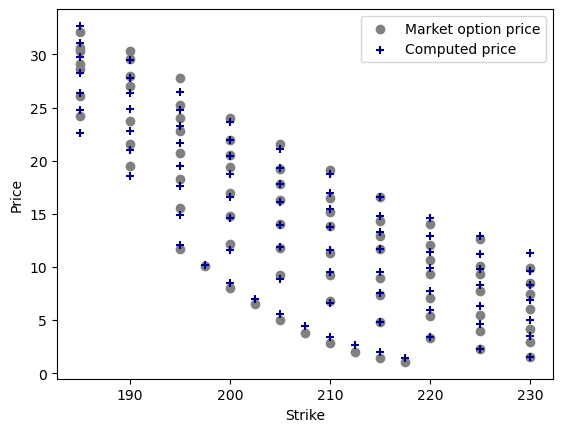

In [80]:
create_option_plot(out)

In [86]:
res2.x

array([ 1.58590623e-01,  8.44596256e+01,  8.21556365e+01, -2.78534414e+00,
        1.72285472e-02])

In [87]:
out = calculate(res2.x, 1)
np.mean(out["error"])

0.8066613251470871

Option pricing with statisitcal daily data

In [34]:
out = calculate([4.0552e-02,  6.0527e+01,  5.5630e+01,  6.5767e-01,  1.0000e-05], 1)

In [35]:
np.mean(out.error)

0.8998209602121335

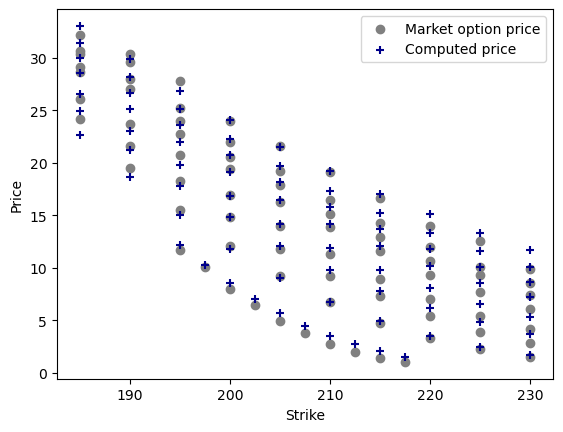

In [36]:
create_option_plot(out, "options_d.pdf")

In [37]:
out.sort_values("error", ascending=False)[:20]

,Expiration,Strike,Price,T,C,error
70,2026-02-20,185.0,29.10,169,33.009800,15.286535
30,2025-10-17,185.0,28.65,79,26.581067,4.280482
41,2025-11-21,190.0,27.00,104,25.112170,3.563901
79,2026-02-20,230.0,9.87,169,11.713037,3.396784
40,2025-11-21,185.0,30.30,104,28.522144,3.160771
10,2025-08-15,185.0,24.20,34,22.676236,2.321857
69,2026-01-16,230.0,8.53,144,10.045010,2.295256
68,2026-01-16,225.0,10.10,144,11.580606,2.192193
61,2026-01-16,190.0,29.55,144,28.106182,2.084611
51,2025-12-19,190.0,27.95,124,26.652641,1.683141


Option pricing with statisitcal 10 minutes data

In [ ]:
out = calculate(
    [7.5425e-01, 4.0617e02, 3.2616e02, -2.3438e-01, 1.0407e-03],
    n_periods_per_day=6.5 * 6,
)  # 6.5 hours of trading per day, 6 periods of 10 min per hour

In [69]:
np.mean(out.error)

9.299887461263625

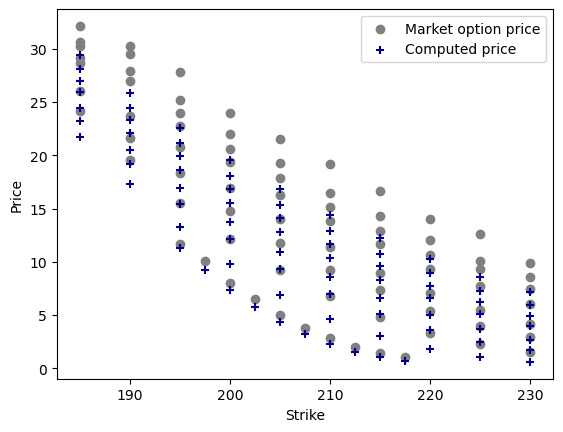

In [41]:
create_option_plot(out, "options_10_m.pdf")

In [40]:
out.sort_values("error", ascending=False)[:20]

,Expiration,Strike,Price,T,C,error
72,2026-02-20,195.0,27.80,169,22.579669,27.251858
61,2026-01-16,190.0,29.55,144,24.482415,25.680419
41,2025-11-21,190.0,27.00,104,22.118344,23.830564
75,2026-02-20,210.0,19.15,169,14.383505,22.719472
74,2026-02-20,205.0,21.56,169,16.838595,22.291665
51,2025-12-19,190.0,27.95,124,23.327716,21.365507
71,2026-02-20,190.0,30.30,169,25.860922,19.705410
73,2026-02-20,200.0,24.00,169,19.570438,19.621015
40,2025-11-21,185.0,30.30,104,25.898379,19.374268
76,2026-02-20,215.0,16.60,169,12.199006,19.368747


Option pricing with statisitcal 10 seconds data

In [ ]:
out = calculate(
    [5.9353e01, 1.6913e03, 1.6691e03, -9.5760e-01, 1.6346e-04],
    n_periods_per_day=6.5 * 60 * 6,
)

In [71]:
np.mean(out.error)

3.956886950479428

In [72]:
out.sort_values("error", ascending=False)[:20]

,Expiration,Strike,Price,T,C,error
41,2025-11-21,190.0,27.00,104,23.173760,14.640116
61,2026-01-16,190.0,29.55,144,25.763623,14.336650
72,2026-02-20,195.0,27.80,169,24.105623,13.648421
40,2025-11-21,185.0,30.30,104,26.803621,12.224665
30,2025-10-17,185.0,28.65,79,25.172815,12.090815
51,2025-12-19,190.0,27.95,124,24.501882,11.889515
71,2026-02-20,190.0,30.30,169,27.263185,9.222246
75,2026-02-20,210.0,19.15,169,16.116320,9.203214
74,2026-02-20,205.0,21.56,169,18.532333,9.166766
60,2026-01-16,185.0,32.15,144,29.234804,8.498367


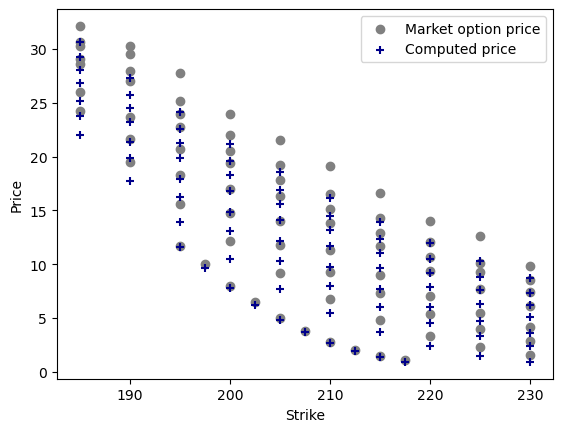

In [73]:
create_option_plot(out)